In [1]:
import f1
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def visualize_training_data(image_fn, preds, labels):
    from PIL import Image, ImageDraw, ImageFont
    fontsize=36
    font = ImageFont.truetype('./NotoSansCJKjp-Regular.otf', fontsize, encoding='utf-8')

    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)

    if type(labels) == str and len(labels) > 0:
        labels = np.array(labels.split(" ")).reshape(-1, 5)
        for codepoint, x, y, w, h in labels:
            x, y, w, h = int(x), int(y), int(w), int(h)
            char = unicode_map[codepoint] # Convert codepoint to actual unicode character

            # Draw bounding box around character, and unicode character next to it
            bbox_draw.rectangle((x, y, x+w, y+h), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
            char_draw.text((x + w + fontsize/4, y + h/2 - fontsize), char, fill=(255, 0, 0, 255), font=font)
        
    if type(preds) == str and len(preds) > 0:
        preds = np.array(preds.split(" ")).reshape(-1, 3) 
        for codepoint, x, y in preds:
            x, y = int(x), int(y)
            char = unicode_map[codepoint]
            bbox_draw.rectangle((x-5, y-5, x+5, y+5), fill=(0,0,255,255))
            char_draw.text((x+25, y-fontsize*(3/4)), char, fill=(0, 0, 255, 255), font=font)


    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

In [19]:
DATA = Path("data")

train_fnames = (DATA/"train_fnames.txt").read_text().split("\n")
valid_fnames = (DATA/"valid_fnames.txt").read_text().split("\n")

df_train = pd.read_csv("data/train.csv")
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('data/unicode_translation.csv').values}

valid_truth = pd.DataFrame(df_train[df_train.image_id.isin([name for name in valid_fnames])].values,
                           columns=["image_id", "labels"])

In [20]:
valid_preds = pd.read_csv("submissions/submission11.valid.csv", index_col=None)

In [22]:
tp = []
fp = []
fn = []
for i in range(len(valid_preds)):
    tp_, fp_, fn_ = f1.score_page(valid_preds.iloc[i].labels, valid_truth.iloc[i].labels).values()
    tp.append(tp_)
    fp.append(fp_)
    fn.append(fn_)
valid_preds["tp"] = tp
valid_preds["fp"] = fp
valid_preds["fn"] = fn

In [23]:
valid_preds.sort_values(by="fn")[::-1].head()

,image_id,labels,tp,fp,fn
291,200021712-00083_1,U+5FA1 140 836 U+5FA1 320 836 U+3076 932 848 U...,267,76,70
339,200021802-00026_1,U+9BC9 280 856 U+6C96 880 860 U+306E 252 1032 ...,171,58,48
396,200021802-00054_2,U+716E 664 892 U+706B 672 940 U+6709 644 1092 ...,187,52,45
397,200021802-00055_1,U+304B 156 864 U+5C71 820 872 U+3078 588 888 U...,165,70,44
331,200021802-00022_1,U+3053 844 868 U+3089 50 1033 U+3060 876 1040 ...,184,46,44


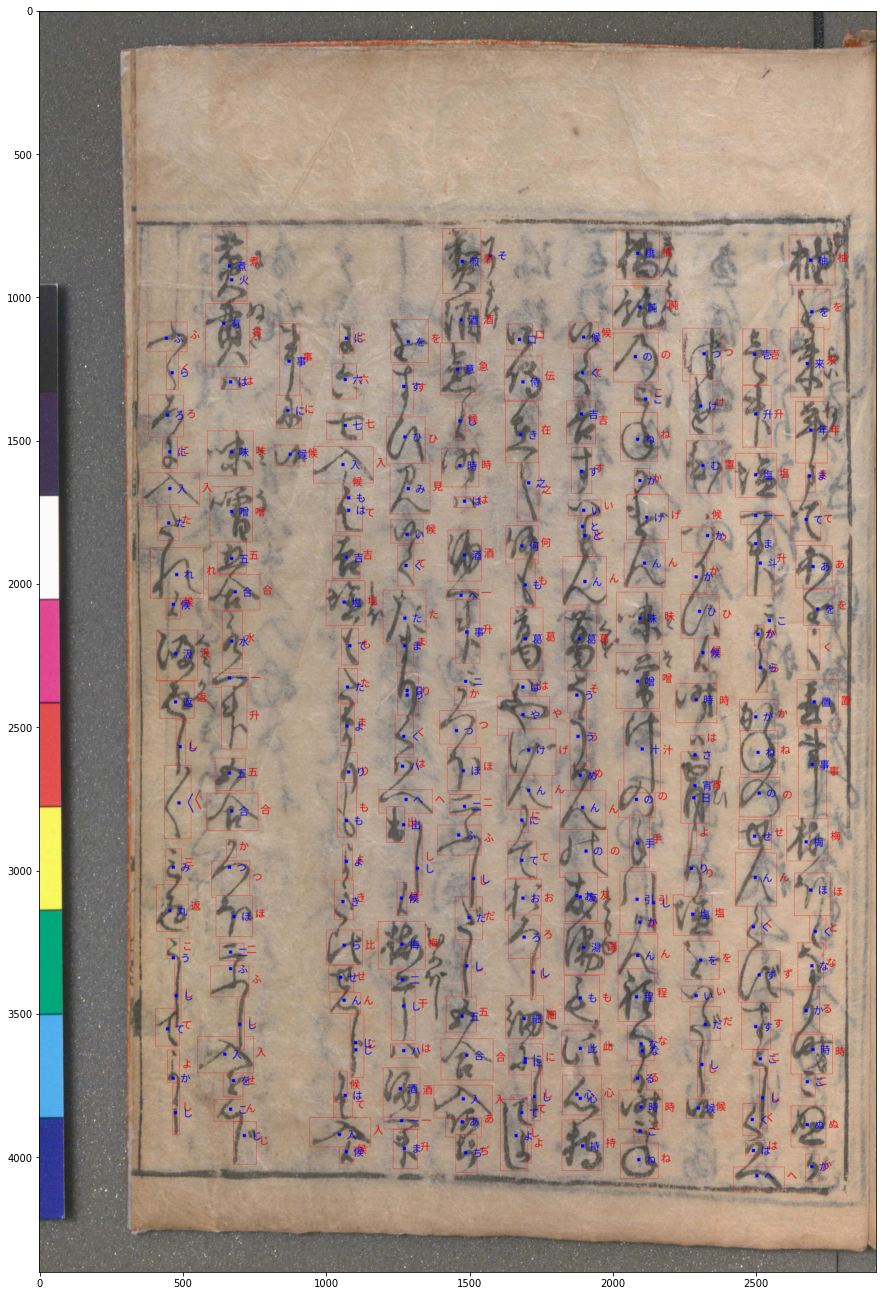

In [26]:
i = 396

viz = visualize_training_data(DATA/"train_images"/(valid_preds.iloc[i].image_id + ".jpg"), valid_preds.iloc[i].labels, valid_truth.iloc[i].labels)
plt.figure(figsize=(15, 25))
#plt.title(img)
plt.imshow(viz, interpolation='bilinear')
plt.show()